# Example use of the pyem package

In [1]:
# import the Emulator class from pyem
from pyem import Emulator

# we also need pyf3d (you can just copy the pyf3d directory over) ...
from pyf3d import Fall3DInputFile, YesNo

# .. and a few other things
import datetime
import numpy as np

## A simple interpolate-and-sum emulator for a linear forward model

In [2]:
# first we need the base Fall3D input file, which will be modified for each run used
# to build the emulator ...

# ... we load the basefile into memory and change a few things ..
file = Fall3DInputFile.from_file("examples/default_so2_reykjanes2.inp")


# ... we change the base date ...
file.time_utc.update({
    'year':2021,
    'month':7,
    'day':18,
    'run_start':0,
    'run_end':48,
})

# ... update a few details about the meteorological data ...
file.meteo_data.update({
    'dbs_end_meteo_data':48,
    'meteo_coupling_interval':3*60,
    'meteo_data_file':'mnt/runs/tests3/test3.nc',
    'meteo_data_dictionary_file':'/home/talfan/Software/Fall3D/RUNS/CARRA.tbl',
    'meteo_levels_file':"/home/talfan/Software/Fall3D/RUNS/L137_ECMWF.levels"
     
})

# ... add the file containing the locations of the specific ground stations we want to 
# keep track of ...
file.model_output.update({
    'output_track_points_file':'examples/stations.pts'
})

# ... some random other stuff just for the example ..
file.model_physics.update({
    'limiter':'MINMOD'
})

# we want to make sure all stochastic options are set to "no" or "off", so that
# the model will always give the same outputs for the same inputs. This is because
# (1) uncertainty is handles by the Bayesian franmework we are using the emulator within, and
# (2) we want to be able to compare emulator performance with that of a reall Fal3D run
file.emsemble_postprocess.update({
    'postprocess_median':YesNo('no')
})

# ... and we set the mass flow rate to 1.0, because the emulator will scale this by the flux we want.
file.source.update({
    'mass_flow_rate':"1.0"
})

WARNING sigma_values_currently_disabled


In [3]:
# Now we have a starting file, we create an emulator object ...
em = Emulator(
        # ... this is the base Fall3D file we just created - it sets the values for options the 
        # emulatror doesn't change (everything except, heigh flux and source_start, basically)
        basefile=file,

        # the starting date for our emulator ...
        start=datetime.datetime(year=2021,month=7, day=18),

        # ... the duration that our emulatort will simulate, in hours ...
        hours=48,

        # ... the heights for whichy our emulatior will be run - 
        # This gives the range and resolution of the look up table used
        # for interpolating the ground concentrations associated with a 'puf'
        # emitted at a specific height
        heights = np.arange(0,2550,50).astype(float),

        # the name of the emulator specifies the directory within /mnt/runs/ in which the
        # emulator runs and the dataframe  describing them are saved
        name = "library_test1",

        # path to Fall3D
        path_fall3d = "/home/talfan/Software/Fall3D_local/fall3d/bin/Fall3d.r8.x"
)


In [4]:
# First we initiualise the emulator, which creates a folder for every run
# needed to build the look up table in mnt/runs/<name>
em.initialise()

In [ ]:
# fetches meteo data for each run
em.get_meteo_data()

In [ ]:
# run everything
em.run()

In [4]:
# processes the data needed for emulating ground concentration on a lat lon grid
em.build_emulator()

In [5]:
# processes the data needed for emulating groiund concentrations at specific points (specified by stations.pts)
em.build_station_emulator()

In [6]:
# runs Fall£d with a random timeseries of Eruption Source Parameters (ESPs) for comparison with emulator output
em.get_emulator_diagnostics(height_low=125.0, height_high=500.0)

WARNING sigma_values_currently_disabled


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.25it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test1/shared_meteo_data.nc , skipping



hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

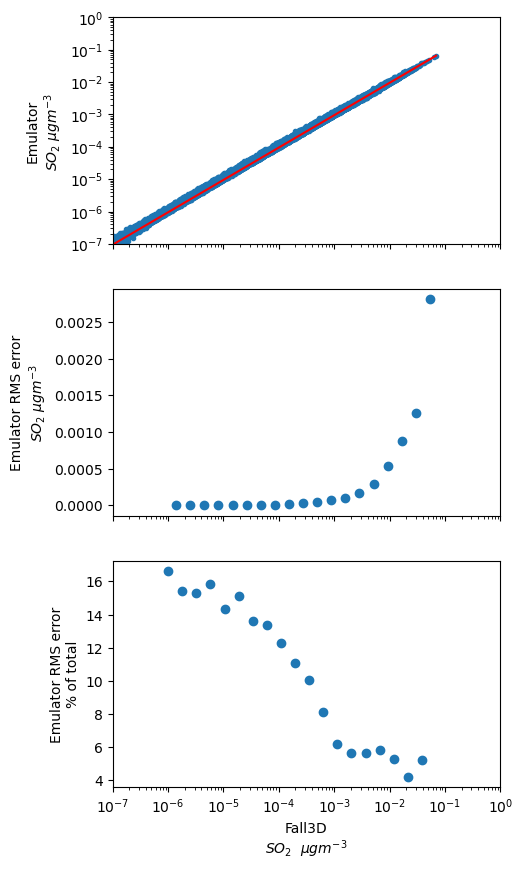

In [7]:
# Plot comparison between emulator and Fall3D for random ESPs
em.plot_emulator_diagnostics()

## A more complicated neural network based emulator

In [6]:
# UNDER DEVELOPMENT!